## Louvain

In [77]:
import random, time, numpy as np, pandas as pd, networkx as nx
from cdlib import algorithms, evaluation
from networkx.algorithms.cuts import conductance

def build_graph(nodes_path="nodes.csv", edges_path="edges.csv"):
    nodes = pd.read_csv(nodes_path)
    edges = pd.read_csv(edges_path)
    nodes["id"] = nodes["id"].astype(str)
    edges["source"] = edges["source"].astype(str)
    edges["target"] = edges["target"].astype(str)
    edges["weight"] = pd.to_numeric(edges["weight"], errors="coerce").fillna(1.0)
    edges = edges[edges["source"] != edges["target"]]
    G = nx.Graph()
    G.add_nodes_from(nodes["id"].tolist())
    G.add_weighted_edges_from(edges[["source","target","weight"]].itertuples(index=False, name=None))
    return G

def coverage_w(G, comms):
    total = G.size(weight="weight")
    intra = sum(G.subgraph(c).size(weight="weight") for c in comms)
    return float(intra/total) if total>0 else 0.0

def conductance_avg(G, comms):
    vals=[]; N=G.number_of_nodes()
    for S in comms:
        if 0 < len(S) < N:
            vS = sum(dict(G.degree(S, weight="weight")).values())
            vT = sum(dict(G.degree(set(G.nodes())-S, weight="weight")).values())
            if min(vS, vT) > 0:
                vals.append(conductance(G, S, weight="weight"))
    return float(np.mean(vals)) if vals else np.nan

def to_sets(cd_part): return [set(c) for c in cd_part.communities]

def one_run(G, seed):
    random.seed(seed); np.random.seed(seed)
    t0=time.time(); coms = algorithms.louvain(G, weight="weight", resolution=1.0); rt=time.time()-t0
    comms = to_sets(coms); sizes = [len(c) for c in comms]
    return {
        "algorithm": "Louvain",
        "trial_seed": seed,
        "runtime": rt,
        "n_comm": len(comms),
        "mean_size": float(np.mean(sizes)) if sizes else 0.0,
        "modularity": evaluation.newman_girvan_modularity(G, coms).score,
        "coverage_w": coverage_w(G, comms),
        "conductance_avg": conductance_avg(G, comms)
    }

# --- Chạy 30 lần và lấy run có modularity cao nhất
G = build_graph("nodes.csv","edges.csv")
BASE, N = 2025, 30
results = [one_run(G, BASE+i) for i in range(N)]
best = max(results, key=lambda r: r["modularity"])

print("== Louvain (best modularity over 30 runs) ==")
for k,v in best.items():
    print(f"{k}: {v}")

df = pd.DataFrame([best])
df.to_csv("community_results.csv", mode="a", index=False, header=not pd.io.common.file_exists("community_results.csv"))

== Louvain (best modularity over 30 runs) ==
algorithm: Louvain
trial_seed: 2039
runtime: 0.04744219779968262
n_comm: 28
mean_size: 20.321428571428573
modularity: 0.6134840626293621
coverage_w: 0.707977207977208
conductance_avg: 0.1918574978500448


## Leiden

In [81]:
import random, time, numpy as np, pandas as pd, networkx as nx
from cdlib import algorithms, evaluation
from networkx.algorithms.cuts import conductance
import os

# --- helpers ---
def build_graph(nodes_path="nodes.csv", edges_path="edges.csv"):
    nodes = pd.read_csv(nodes_path); edges = pd.read_csv(edges_path)
    nodes["id"] = nodes["id"].astype(str)
    edges["source"] = edges["source"].astype(str)
    edges["target"] = edges["target"].astype(str)
    edges["weight"] = pd.to_numeric(edges["weight"], errors="coerce").fillna(1.0)
    edges = edges[edges["source"] != edges["target"]]
    G = nx.Graph()
    G.add_nodes_from(nodes["id"].tolist())
    G.add_weighted_edges_from(edges[["source","target","weight"]].itertuples(index=False, name=None))
    return G

def coverage_w(G, comms):
    total = G.size(weight="weight")
    intra = sum(G.subgraph(c).size(weight="weight") for c in comms)
    return float(intra/total) if total>0 else 0.0

def conductance_avg(G, comms):
    vals=[]; N=G.number_of_nodes()
    for S in comms:
        if 0<len(S)<N:
            vS=sum(dict(G.degree(S,weight="weight")).values())
            vT=sum(dict(G.degree(set(G.nodes())-S,weight="weight")).values())
            if min(vS,vT)>0: vals.append(conductance(G,S,weight="weight"))
    return float(np.mean(vals)) if vals else np.nan

def to_sets(cd_part): return [set(c) for c in cd_part.communities]

# --- one run (Leiden) ---
def one_run_leiden(G, seed):
    random.seed(seed); np.random.seed(seed)
    t0=time.time(); coms = algorithms.leiden(G); rt=time.time()-t0
    comms=to_sets(coms); sizes=[len(c) for c in comms]
    return {
        "algorithm": "Leiden",
        "trial_seed": seed,
        "runtime": rt,
        "n_comm": len(comms),
        "mean_size": float(np.mean(sizes)) if sizes else 0.0,
        "modularity": evaluation.newman_girvan_modularity(G, coms).score,
        "coverage_w": coverage_w(G, comms),
        "conductance_avg": conductance_avg(G, comms)
    }

# --- run 30 and append best to CSV ---
if __name__=="__main__":
    G = build_graph("nodes.csv","edges.csv")
    BASE, N = 2025, 30
    results = [one_run_leiden(G, BASE+i) for i in range(N)]
    best = max(results, key=lambda r: r["modularity"])

    print("== Leiden (best modularity over 30 runs) ==")
    for k,v in best.items():
        print(f"{k}: {v}")

    csv_path = "community_results.csv"
    df = pd.DataFrame([best])
    header = not os.path.exists(csv_path)
    df.to_csv(csv_path, mode="a", index=False, header=header)

== Leiden (best modularity over 30 runs) ==
algorithm: Leiden
trial_seed: 2044
runtime: 0.021533966064453125
n_comm: 26
mean_size: 21.884615384615383
modularity: 0.6087813410605435
coverage_w: 0.6954415954415955
conductance_avg: 0.19638663232103018


## Infomap

In [83]:
import os, time, random, numpy as np, pandas as pd, networkx as nx
from cdlib import algorithms, evaluation
from networkx.algorithms.cuts import conductance

def build_graph(nodes_path="nodes.csv", edges_path="edges.csv"):
    nodes = pd.read_csv(nodes_path); edges = pd.read_csv(edges_path)
    nodes["id"] = nodes["id"].astype(str)
    edges["source"] = edges["source"].astype(str)
    edges["target"] = edges["target"].astype(str)
    edges["weight"] = pd.to_numeric(edges["weight"], errors="coerce").fillna(1.0)
    edges = edges[edges["source"] != edges["target"]]
    G = nx.Graph()
    G.add_nodes_from(nodes["id"].tolist())
    G.add_weighted_edges_from(edges[["source","target","weight"]].itertuples(index=False, name=None))
    return G

def coverage_w(G, comms):
    total = G.size(weight="weight")
    intra = sum(G.subgraph(c).size(weight="weight") for c in comms)
    return float(intra/total) if total>0 else 0.0

def conductance_avg(G, comms):
    vals=[]; N=G.number_of_nodes()
    for S in comms:
        if 0<len(S)<N:
            vS=sum(dict(G.degree(S,weight="weight")).values())
            vT=sum(dict(G.degree(set(G.nodes())-S,weight="weight")).values())
            if min(vS,vT)>0: vals.append(conductance(G,S,weight="weight"))
    return float(np.mean(vals)) if vals else np.nan

def to_sets(cd_part): return [set(c) for c in cd_part.communities]

def run_infomap_once(G, seed):
    random.seed(seed); np.random.seed(seed)
    t0=time.time(); coms=algorithms.infomap(G); rt=time.time()-t0
    comms=to_sets(coms); sizes=[len(c) for c in comms]
    return {
        "algorithm":"Infomap",
        "trial_seed":seed,
        "runtime":rt,
        "n_comm":len(comms),
        "mean_size":float(np.mean(sizes)) if sizes else 0.0,
        "modularity":evaluation.newman_girvan_modularity(G,coms).score,
        "coverage_w":coverage_w(G,comms),
        "conductance_avg":conductance_avg(G,comms)
    }

def best_over_runs(G, n=30, base_seed=2025, csv_path="community_results.csv"):
    results=[run_infomap_once(G, base_seed+i) for i in range(n)]
    best=max(results, key=lambda x: x["modularity"])
    print("== Infomap (best of", n, "runs) ==")
    for k,v in best.items(): print(f"{k}: {v}")
    df=pd.DataFrame([best]); header=not os.path.exists(csv_path)
    df.to_csv(csv_path, mode="a", index=False, header=header)

if __name__=="__main__":
    G=build_graph("nodes.csv","edges.csv")
    best_over_runs(G, n=30, base_seed=2025, csv_path="community_results.csv")

== Infomap (best of 30 runs) ==
algorithm: Infomap
trial_seed: 2031
runtime: 0.0843970775604248
n_comm: 57
mean_size: 9.982456140350877
modularity: 0.5717944253699241
coverage_w: 0.6136752136752137
conductance_avg: 0.34520297461986144


## Label Propagation (LPA)

In [84]:
import os, time, random, numpy as np, pandas as pd, networkx as nx
from cdlib import algorithms, evaluation
from networkx.algorithms.cuts import conductance

def build_graph(nodes_path="nodes.csv", edges_path="edges.csv"):
    nodes = pd.read_csv(nodes_path); edges = pd.read_csv(edges_path)
    nodes["id"] = nodes["id"].astype(str)
    edges["source"] = edges["source"].astype(str)
    edges["target"] = edges["target"].astype(str)
    edges["weight"] = pd.to_numeric(edges["weight"], errors="coerce").fillna(1.0)
    edges = edges[edges["source"] != edges["target"]]
    G = nx.Graph()
    G.add_nodes_from(nodes["id"].tolist())
    G.add_weighted_edges_from(edges[["source","target","weight"]].itertuples(index=False, name=None))
    return G

def coverage_w(G, comms):
    total = G.size(weight="weight")
    intra = sum(G.subgraph(c).size(weight="weight") for c in comms)
    return float(intra/total) if total>0 else 0.0

def conductance_avg(G, comms):
    vals=[]; N=G.number_of_nodes()
    for S in comms:
        if 0<len(S)<N:
            vS=sum(dict(G.degree(S,weight="weight")).values())
            vT=sum(dict(G.degree(set(G.nodes())-S,weight="weight")).values())
            if min(vS,vT)>0: vals.append(conductance(G,S,weight="weight"))
    return float(np.mean(vals)) if vals else np.nan

def to_sets(cd_part): return [set(c) for c in cd_part.communities]

def run_lpa_once(G, seed):
    random.seed(seed); np.random.seed(seed)
    t0=time.time()
    coms = algorithms.label_propagation(G)  # LPA thường không dùng weight
    rt=time.time()-t0
    comms=to_sets(coms); sizes=[len(c) for c in comms]
    return {
        "algorithm":"LabelPropagation",
        "trial_seed":seed,
        "runtime":rt,
        "n_comm":len(comms),
        "mean_size":float(np.mean(sizes)) if sizes else 0.0,
        "modularity":evaluation.newman_girvan_modularity(G,coms).score,
        "coverage_w":coverage_w(G,comms),
        "conductance_avg":conductance_avg(G,comms)
    }

def best_over_runs(G, n=30, base_seed=2025, csv_path="community_results.csv"):
    results=[run_lpa_once(G, base_seed+i) for i in range(n)]
    best=max(results, key=lambda x: x["modularity"])
    print(f"== Label Propagation (best of {n} runs) ==")
    for k,v in best.items(): print(f"{k}: {v}")
    df=pd.DataFrame([best]); header=not os.path.exists(csv_path)
    df.to_csv(csv_path, mode="a", index=False, header=header)

if __name__=="__main__":
    G=build_graph("nodes.csv","edges.csv")
    best_over_runs(G, n=30, base_seed=2025, csv_path="community_results.csv")

== Label Propagation (best of 30 runs) ==
algorithm: LabelPropagation
trial_seed: 2025
runtime: 0.012955904006958008
n_comm: 38
mean_size: 14.973684210526315
modularity: 0.4342467999448056
coverage_w: 0.8290598290598291
conductance_avg: 0.27696522280306846


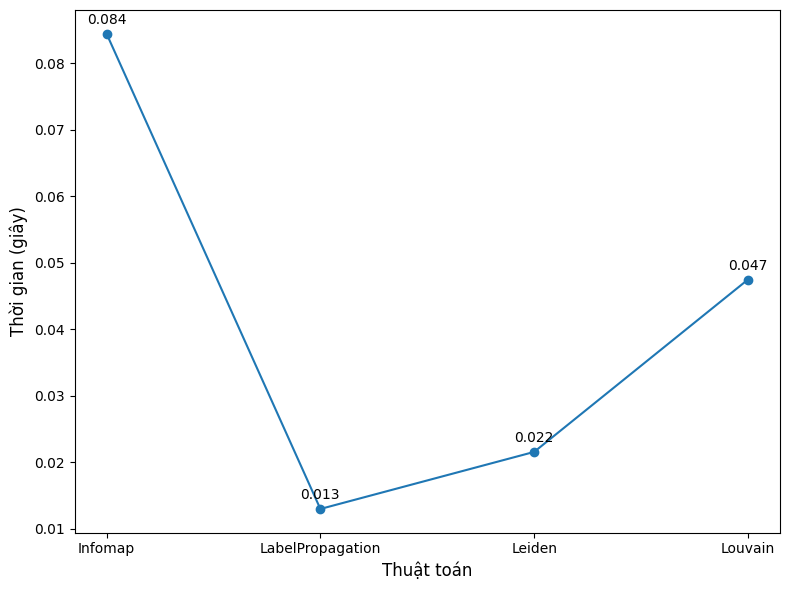

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu
df = pd.read_csv("community_results.csv")
df_unique = df.groupby("algorithm", as_index=False).first()

# Vẽ biểu đồ đường (không grid, không title)
plt.figure(figsize=(8,6))
plt.plot(df_unique["algorithm"], df_unique["runtime"], marker="o", linestyle="-", color="#1f77b4")

plt.ylabel("Thời gian (giây)", fontsize=12)
plt.xlabel("Thuật toán", fontsize=12)

# Hiển thị giá trị tại các điểm
for x, y in zip(df_unique["algorithm"], df_unique["runtime"]):
    plt.text(x, y + 0.001, f"{y:.3f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()